# Дз 2: Масштабирование регуляризация

## Задача 1 
Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

In [562]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

%matplotlib inline

np.random.seed(1234)

### Generating Dataset 

In [563]:
data, target, coef = datasets.make_regression(n_samples=int(1e4), n_features = 2, n_informative = 2, n_targets = 1, 
                                              noise = 7, coef = True, random_state = 2)


#### Произведем стандартизацию

In [564]:
# Получим средние значения и стандартное отклонение по столбцам
 
means = np.mean(data, axis=0)
stds = np.std(data, axis=0)
# параметр axis указывается для вычисления значений по столбцам, а не по всему массиву
#(см. документацию в разделе источников)
 
# вычтем каждое значение признака из среднего и поделим на стандартное отклонение
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        data[i][j] = (data[i][j] - means[j])/stds[j]

In [565]:
data.shape

(10000, 2)

In [566]:
coef

array([47.46102593,  1.66486956])

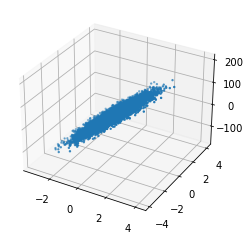

In [567]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], target,s = 2, label='parametric curve')


plt.show()

Ничего непонятно. Что делает __n_informative__? По картинке я скорее ожидал бы, что этот показатель == 1

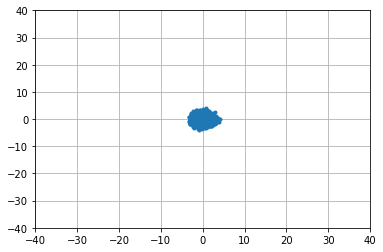

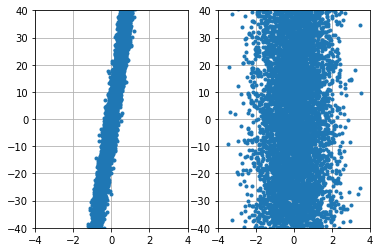

In [568]:
plt.plot(data[:,0],data[:,1], '.')
plt.xlim((-40,40))
plt.ylim((-40,40))
plt.grid(True)
plt.show()
plt.subplot(1,2,1)
plt.plot(data[:,0],target, '.')
plt.xlim((-4,4))
plt.ylim((-40,40))
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(data[:,1],target, '.')
plt.xlim((-4,4))
plt.ylim((-40,40))
plt.grid(True)

plt.show()

Вектор единиц в начало.

In [569]:
X = np.append(np.ones(data.shape[0]).reshape(data.shape[0], 1), data, axis = 1)
X

array([[ 1.00000000e+00, -2.77754356e-01,  3.85504659e-01],
       [ 1.00000000e+00, -7.44773351e-01,  6.35711699e-01],
       [ 1.00000000e+00,  1.73972197e+00,  1.37197680e+00],
       ...,
       [ 1.00000000e+00,  9.87897050e-02,  1.12821753e+00],
       [ 1.00000000e+00,  5.74331592e-01,  8.75901031e-04],
       [ 1.00000000e+00, -8.16160421e-01, -7.77581502e-01]])

In [570]:
y = target
#y = y.reshape(-1, 10000)

#### Функции из предыдущего дз 
...нам пригодятся:

In [571]:
def calc_mae(y, y_pred):
    err = np.mean(np.abs(y - y_pred))
    return err

def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2) # <=> 1/n * np.sum((y_pred - y)**2)
    return err

In [572]:
def grad_desc(X, y, alpha = 0.4):
    i = 0 
    eps = 1e-16
    err_prev = 0.
    errors = []
    n = X.shape[0]
    W = np.ones(X.shape[1]) 
    print(f'n: {X.shape}\t')
    while 1:
        y_pred = np.dot(X, W)
        err = calc_mse(y, y_pred)
        errors.append(err)
        W -= alpha * (1/n * 2 * X.T @ (y_pred - y))
        if i % 10 == 0:
            print(f'Err - err_prev: {err - err_prev}\tMSE: {err}')
        if (np.abs(err - err_prev) <= eps):
            print(f'Stopping on {i}th step\tMSE: {err}')
            return W, err, errors
        err_prev = err
        if i % 10 == 0:
            alpha *= 0.9
        if i >= 1e+6:
            print(f'too many iterations\nAlpha = {alpha} : \tMSE: {err}')
            return W, err, errors
        i+=1

#### Приступим к самому обучению

In [573]:
start_time = time.time()
W, err, errors = grad_desc(X, y)
time_spent = (time.time() - start_time)
print(f'\nВремени на это потрачено: {time_spent}')

n: (10000, 3)	
Err - err_prev: 2191.622268632889	MSE: 2191.622268632889
Err - err_prev: -1.3157837486232893e-07	MSE: 49.342362247796494
Err - err_prev: 0.0	MSE: 49.34236223615021
Stopping on 20th step	MSE: 49.34236223615021

Времени на это потрачено: 0.008886098861694336


#### Это нормально? 1 млн размер выборки - считается за полсекунды?

In [574]:
W

array([-7.33397059e-03,  4.72609632e+01,  1.64252071e+00])

#### Лучшая ошибка

In [575]:
errors[-1]

49.34236223615021

#### График ошибки

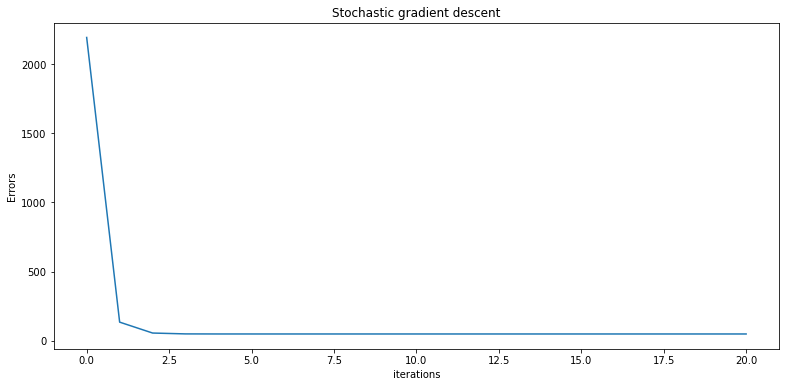

In [576]:
# Визуализируем изменение ошибки

plt.figure(figsize=(13, 6))
plt.title('Stochastic gradient descent')
plt.xlabel('iterations')
plt.ylabel('Errors')

#plt.xlim(0, 5000)

plt.plot(errors)


plt.show()

### Теперь реализуем Стохастический Градиентный Спуск

In [577]:
def stochastic_grad_desc(X, y, alpha = 0.5):
    i = 0 
    eps = 1e-8
    err_prev = 0.
    n = X.shape[0]
    W = np.ones(X.shape[1]) 
    w_list = [W.copy()]
    errors = []
    weight_dist = np.inf
    weight_dist_list = []
    
    # счетчик итераций
    iter_num = 0

    np.random.seed(1234)

    while 1:
        # generating index 
        train_ind = np.random.randint(data.shape[0])
        
        new_W = W - alpha * ( 1./n * 2 * np.dot(X[train_ind].T, (np.dot(X[train_ind], W) - y[train_ind])))
    
        if iter_num % 100000 == 0:
            print(f'\tStep {iter_num}')
        w_list.append(new_W.copy())
        errors.append(calc_mse(y, np.dot(X, W)))
        
        iter_num += 1
        weight_dist = np.linalg.norm(new_W - W, ord=2)
        weight_dist_list.append(weight_dist)
        W = new_W
        
        

        if (weight_dist < eps):
            print('W has stabilized')
            break
        if (iter_num >= 1e+6):
            print('Iterations are running out')
            break
    return w_list, errors, weight_dist_list

In [578]:
start_time = time.time()
w_list, errors1, weight_dist = stochastic_grad_desc(X, y)
time_spent = (time.time() - start_time)
print(f'\nВремени на это потрачено: {time_spent}')


	Step 0
	Step 100000
W has stabilized

Времени на это потрачено: 13.542206048965454


In [579]:
len(w_list)

116161

#### Вывод: жутко уступает в скорости обучения и точности обычному градиентному спуску. Работает хорошо и точно только на маленьких выборках, да и тот уступая первому. Где ошибка?

In [580]:
w_list[-1], errors1[-1]

(array([-2.69210711e-02,  4.72226735e+01,  1.69536450e+00]), 49.34695165902069)

In [581]:
len(w_list)

116161

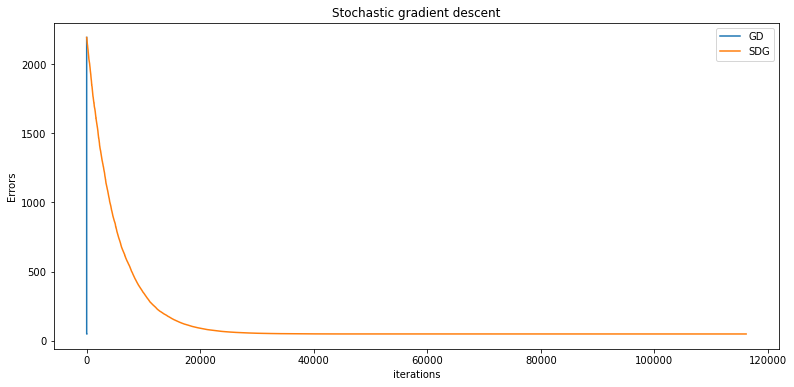

In [582]:
# Визуализируем изменение errors

plt.figure(figsize=(13, 6))
plt.title('Stochastic gradient descent')
plt.xlabel('iterations')
plt.ylabel('Errors')

#plt.xlim(0, 5000)

plt.plot(errors, label = 'GD')
#plt.plot(range(int(0.5*1e5)), errors1[:int(0.5*1e5)])
plt.plot(errors1, label = 'SDG')

plt.legend()

plt.show()

#### По графику видно, что все, проделанное ранее, вообще как-то не очень.

Вообще, в чем смысл этого графика? Понятно, что у СГС будет больше шагов, вопрос, как быстро будет находиться ответ: мы же расчитываем на оптимизацию за счет "дешевизны" каждого шага? В любом случае, оптимизации я не наблюдаю - напротив.

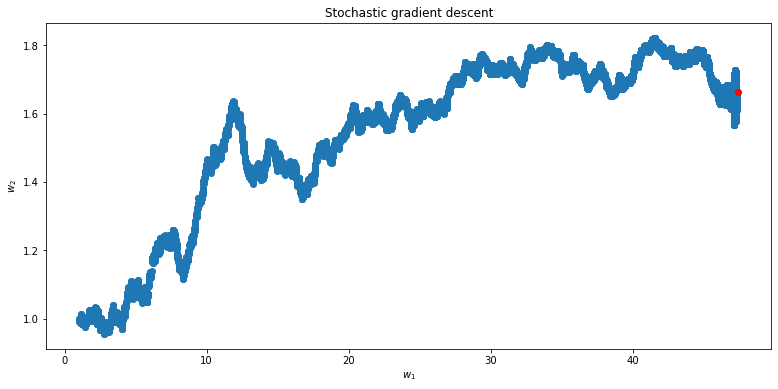

In [583]:
# Визуализируем изменение весов (красной точкой обозначены истинные веса, сгенерированные вначале)
plt.figure(figsize=(13, 6))
plt.title('Stochastic gradient descent')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')

plt.scatter(np.array(w_list)[:, 1], np.array(w_list)[:, 2])
plt.scatter(coef[0], coef[1], c='r')
# plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

#### Что-то ну вот как-то совсем вроде бы, как сказать, даже не знаю

## Задача 2
Модифицировать решение первого задания путем добавления  𝐿2 -регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

$$
\lambda \|w\|^2 = \lambda\cdot(\omega_0^2 + ... + \omega_n^2)
$$

$$
\nabla (\lambda\cdot\|\omega\|) = 2\lambda (\omega_0, ... , \omega_n)
$$


In [597]:
def stochastic_grad_desc_L2(X, y, alpha = 0.5, lambda_ = 0.01):
    i = 0 
    eps = 1e-8
    err_prev = 0.
    n = X.shape[0]
    W = np.ones(X.shape[1]) 
    w_list = [W.copy()]
    errors = []
    weight_dist = np.inf
    weight_dist_list = []
    
    # счетчик итераций
    iter_num = 0

    np.random.seed(1234)

    while 1:
        # generating index 
        train_ind = np.random.randint(data.shape[0])
        
# Введем штраф
        new_W = W - alpha * ( 1./n * 2 * np.dot(X[train_ind].T, (np.dot(X[train_ind], W) - y[train_ind]))) - 2*np.dot(lambda_, W)
    
        if iter_num % 100000 == 0:
            print(f'\tStep {iter_num}')
        w_list.append(new_W.copy())
        errors.append(calc_mse(y, np.dot(X, W)))
        
        iter_num += 1
        weight_dist = np.linalg.norm(new_W - W, ord=2)
        weight_dist_list.append(weight_dist)
        W = new_W
        
        

        if (weight_dist < eps):
            print('W has stabilized')
            break
        if (iter_num >= 1e+6):
            print('Iterations are running out')
            break
    return w_list, errors, weight_dist_list

In [598]:
start_time = time.time()
w_list2, errors2, weight_dist2 = stochastic_grad_desc_L2(X, y)
time_spent = (time.time() - start_time)
print(f'\nВремени на это потрачено: {time_spent}')


	Step 0
	Step 100000
	Step 200000
	Step 300000
	Step 400000
	Step 500000
	Step 600000
	Step 700000
	Step 800000
	Step 900000
Iterations are running out

Времени на это потрачено: 95.2142870426178


In [599]:
w_list2[-1], errors2[-1]

(array([ 0.04422869,  0.24834088, -0.00264343]), 2264.034903024172)

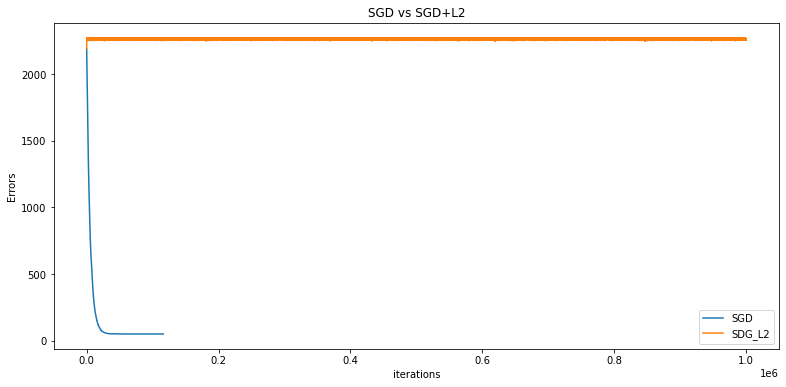

In [600]:
# Визуализируем изменение errors

plt.figure(figsize=(13, 6))
plt.title('SGD vs SGD+L2')
plt.xlabel('iterations')
plt.ylabel('Errors')

#plt.xlim(0, 5000)

plt.plot(errors1, label = 'SGD')
#plt.plot(range(int(0.5*1e5)), errors1[:int(0.5*1e5)])
plt.plot(errors2, label = 'SDG_L2')

plt.legend()

plt.show()

Зачем нам в этом примере регуляризация? Мы угадываем линейную функцию, и, худо-бедно мы приходим к правильным коэффициентам. Откуда у нас возьмется переобучение, с которым надо бороться?
